In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from collections import Counter
# from conlleval import evaluate

print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")

Tensorflow version: 2.10.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
data = pd.read_parquet('../kaggle/input/cord-ner-full.parquet.gzip')
# data = pd.read_csv('../kaggle/input/covid_subset_0.5perc.csv')
data

,word,entity,sentence
0,angiotensin-converting,B-GENE_OR_GENOME,0
1,enzyme,I-GENE_OR_GENOME,0
2,2,I-GENE_OR_GENOME,0
3,ace2,B-GENE_OR_GENOME,0
4,as,Other,0
...,...,...,...
63308695,advise,I-CHEMICAL,140498
63308696,caution,I-CHEMICAL,140498
63308697,in,I-CHEMICAL,140498
63308698,interpreting,I-CHEMICAL,140498


In [3]:
print(f"Number of unique entities: {len(data['entity'].unique())}")
data['entity'].unique()

Number of unique entities: 125


array(['B-GENE_OR_GENOME', 'I-GENE_OR_GENOME', 'Other', 'B-CORONAVIRUS',
       'B-CHEMICAL', 'B-EVOLUTION', 'B-WILDLIFE', 'B-NORP', 'I-NORP',
       'B-ORGANISM', 'B-EUKARYOTE', 'B-PERSON', 'I-PERSON',
       'B-PHYSICAL_SCIENCE', 'I-PHYSICAL_SCIENCE', 'I-CHEMICAL',
       'B-DISEASE_OR_SYNDROME', 'I-DISEASE_OR_SYNDROME', 'I-ORGANISM',
       'B-DATE', 'B-CARDINAL', 'B-MOLECULAR_FUNCTION',
       'B-EXPERIMENTAL_MODEL_OF_DISEASE',
       'I-EXPERIMENTAL_MODEL_OF_DISEASE', 'B-CELL',
       'B-BODY_PART_ORGAN_OR_ORGAN_COMPONENT', 'B-LIVESTOCK', 'B-ORG',
       'B-TISSUE', 'I-TISSUE', 'B-GROUP', 'I-CELL', 'B-CELL_COMPONENT',
       'I-CELL_COMPONENT', 'B-FOOD', 'B-CELL_FUNCTION', 'I-DATE', 'B-GPE',
       'B-DAILY_OR_RECREATIONAL_ACTIVITY', 'B-BODY_SUBSTANCE',
       'B-INDIVIDUAL_BEHAVIOR', 'B-GOVERNMENTAL_OR_REGULATORY_ACTIVITY',
       'B-ORDINAL', 'B-LABORATORY_PROCEDURE', 'I-LABORATORY_PROCEDURE',
       'B-VIRUS', 'B-PRODUCT', 'B-SIGN_OR_SYMPTOM',
       'B-LABORATORY_OR_TEST_RESUL

In [4]:
words = list(set(data['word'].values))
words.append("ENDPAD")
num_words = len(words)

tags = list(set(data['entity'].values))
num_tags = len(tags)

In [5]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['entity'].values.tolist())]
        self.grouped = self.data.groupby('sentence').apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

# Init SentenceGetter object to preprocess and parse dataset into separate sentences
# 'sentences' object is an array of arrays, which contains tuples of word-entity pairs
getter = SentenceGetter(data)
sentences = getter.sentences
sentences[:1]

[[('angiotensin-converting', 'B-GENE_OR_GENOME'),
  ('enzyme', 'I-GENE_OR_GENOME'),
  ('2', 'I-GENE_OR_GENOME'),
  ('ace2', 'B-GENE_OR_GENOME'),
  ('as', 'Other'),
  ('a', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('receptor', 'B-CHEMICAL'),
  ('molecular', 'Other'),
  ('mechanisms', 'Other'),
  ('and', 'Other'),
  ('potential', 'Other'),
  ('therapeutic', 'Other'),
  ('target', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('has', 'Other'),
  ('been', 'Other'),
  ('sequenced', 'Other'),
  ('[3]', 'Other'),
  ('.', 'Other'),
  ('a', 'Other'),
  ('phylogenetic', 'B-EVOLUTION'),
  ('analysis', 'Other'),
  ('[3,', 'Other'),
  ('4]', 'Other'),
  ('found', 'Other'),
  ('a', 'Other'),
  ('bat', 'B-WILDLIFE'),
  ('origin', 'Other'),
  ('for', 'Other'),
  ('the', 'Other'),
  ('sars-cov-2', 'B-CORONAVIRUS'),
  ('there', 'Other'),
  ('is', 'Other'),
  ('a', 'Other'),
  ('diversity', 'Other'),
  ('of', 'Other'),
  ('possible', 'Other'),
  ('intermediate', 'B-NORP'),
  ('hosts', 'I-NORP'),
 

In [6]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

max_len = data.groupby(['sentence'], sort=False).size().max()

x = [[word2idx[w[0]] for w in s] for s in sentences]
x = pad_sequences(maxlen=max_len, sequences=x, padding="post", value=word2idx["ENDPAD"])

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx['Other'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Transformer block and NER model creation

In [7]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = tf.reshape(
            tf.transpose(tf.reshape(query, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        key = tf.reshape(
            tf.transpose(tf.reshape(key, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )
        value = tf.reshape(
            tf.transpose(tf.reshape(value, (batch_size, -1, self.num_heads, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size * self.num_heads, -1, self.head_dim),
        )

        attention_logits = tf.matmul(query, key, transpose_b=True)
        attention_logits = attention_logits / tf.math.sqrt(tf.cast(self.head_dim, tf.float32))
        attention_weights = tf.nn.softmax(attention_logits, axis=-1)

        output = tf.matmul(attention_weights, value)
        output = tf.reshape(
            tf.transpose(tf.reshape(output, (batch_size, self.num_heads, -1, self.head_dim)), perm=[0, 2, 1, 3]),
            (batch_size, -1, self.embed_dim),
        )
        output = self.combine_heads(output)
        return output

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
#         self.att = keras.layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=embed_dim
#         )
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output)
#         out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(inputs + ffn_output)

In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [10]:
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32, num_layers=1, rate=0.1
    ):
        super().__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#         self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.ff_final(x)
        return x

In [12]:
with strategy.scope():
    learning_rate = 0.0008
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    ner_model = NERModel(num_tags, len(words), embed_dim=128, num_heads=2, ff_dim=num_tags*4, num_layers=2, rate=0.2)
    ner_model.compile(optimizer=optimizer, 
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
    history = ner_model.fit(
        x=x_train,
        y=y_train,
        validation_split=0.1,
        batch_size=int(max_len/4),
        epochs=8,
        verbose=1
    )

Epoch 1/8
788/788 [==============================] - 87s 107ms/step - loss: 0.5345 - accuracy: 0.8640 - val_loss: 0.4485 - val_accuracy: 0.8768
Epoch 2/8
788/788 [==============================] - 84s 107ms/step - loss: 0.4310 - accuracy: 0.8806 - val_loss: 0.4196 - val_accuracy: 0.8829
Epoch 3/8
788/788 [==============================] - 84s 107ms/step - loss: 0.3939 - accuracy: 0.8891 - val_loss: 0.3938 - val_accuracy: 0.8892
Epoch 4/8
788/788 [==============================] - 84s 107ms/step - loss: 0.3637 - accuracy: 0.8955 - val_loss: 0.3881 - val_accuracy: 0.8897
Epoch 5/8
788/788 [==============================] - 84s 107ms/step - loss: 0.3400 - accuracy: 0.9005 - val_loss: 0.3825 - val_accuracy: 0.8915
Epoch 6/8
788/788 [==============================] - 84s 107ms/step - loss: 0.3188 - accuracy: 0.9051 - val_loss: 0.3871 - val_accuracy: 0.8921
Epoch 7/8
788/788 [==============================] - 84s 107ms/step - loss: 0.2995 - accuracy: 0.9095 - val_loss: 0.3959 - val_accuracy:

In [16]:
def plot_history(history):
    plt.style.use('ggplot')
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

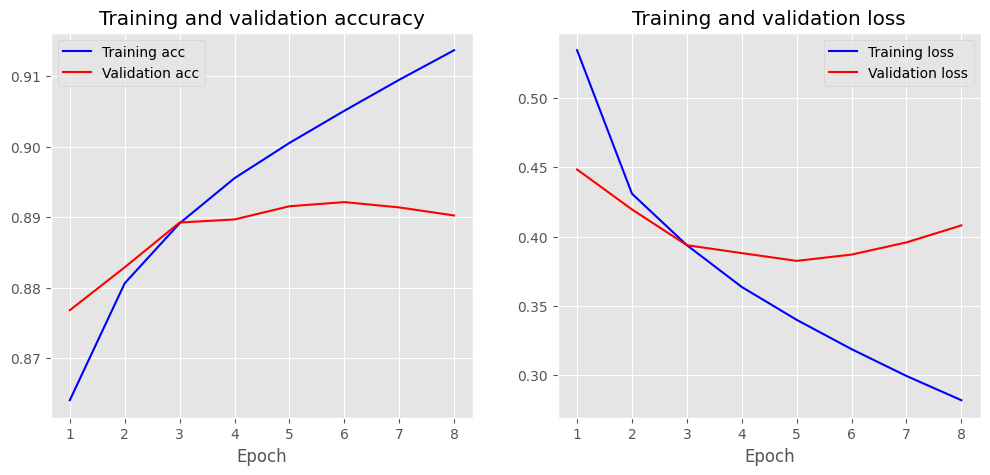

In [17]:
plot_history(history)

In [18]:
for i in range(3):
    p = ner_model.predict(np.array([x_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
    print("-" * 30)
    for w, true, pred in zip(x_test[i], y_true, p[0]):
        if words[w] == "ENDPAD":
            break
        print("{:15}{}\t{}".format(words[w], tags[true], tags[pred]))
    print("----------------------------")

1/1 [==============================] - 1s 1s/step
Word           True 	 Pred

------------------------------
ranked         Other	Other
either         Other	Other
by             Other	Other
p              B-GENE_OR_GENOME	B-GENE_OR_GENOME
value          I-GENE_OR_GENOME	I-GENE_OR_GENOME
(eigenstrat,   Other	Other
emmax-grm      B-CHEMICAL	B-CHEMICAL
and            Other	Other
fvr            B-GENE_OR_GENOME	B-GENE_OR_GENOME
or             Other	Other
by             Other	Other
pve            B-GENE_OR_GENOME	B-GENE_OR_GENOME
gblup          B-CHEMICAL	Other
from           Other	Other
1              Other	Other
(most          Other	Other
significant    Other	Other
snp)           Other	Other
to             Other	Other
2,000.         Other	Other
for            Other	Other
comparisons    Other	Other
of             Other	Other
snps           Other	Other
that           Other	Other
were           Other	Other
associated     Other	Other
with           Other	Other
brdc           Other	Other
susce

1/1 [==============================] - 0s 43ms/step
Word           True 	 Pred

------------------------------
cytrx          I-ORG	B-ORG
corporation    I-ORG	I-ORG
are            Other	Other
concentrated   Other	Other
in             Other	Other
the            Other	Other
development    Other	Other
of             Other	Other
small          B-PERSON	B-GENE_OR_GENOME
molecule       I-PERSON	Other
drugs          B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE	B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE
rnai           B-MOLECULAR_FUNCTION	B-MOLECULAR_FUNCTION
drug           Other	B-GENE_OR_GENOME
discovery      Other	I-GENE_OR_GENOME
and            Other	Other
dna            B-CELL_COMPONENT	B-CELL_COMPONENT
vaccines       B-CHEMICAL	B-CHEMICAL
and            Other	Other
a              Other	Other
delivery       Other	Other
technology     Other	Other
with           Other	Other
multiple       Other	Other
applications   B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE	B-THERAPEUTIC_OR_PREVENTIVE_PROCEDURE
in          